In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [12]:
%%time
b_modes = 3
t_modes = 3

p = rw.base_params(b_modes+t_modes+2)

#p.w_g = mf.ModelSymbol(value = 0,string='w_g')
#p.k_fwt = mf.ModelSymbol(value = 0, string = 'k_fwt')
#p.m_ac = mf.ModelSymbol(value = 100,string = 'm_ac')
#p.k_ac = mf.ModelSymbol(value = 1e6, string = 'k_ac')

#p.yaw = mf.ModelSymbol(value = 0, string = 'theta')

#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[1:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)
wing_bend = sym.atan(z_0.diff(p.y_0).subs({p.x_0:p.x_f0,p.y_0:p.s_0}))

#define wrefernce frames

wing_root_frame = mf.HomogenousTransform().Translate(0,0,p.q[0]).R_y(p.alpha_r)

wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.msubs({p.x_0:p.x_f0})

fwt_root_frame = wing_frame.msubs({p.y_0:p.s_0,p.x_0:p.x_f0}).Translate(-p.x_f0,0,0).R_x(-p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(p.x_f1,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.c/2,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=True)

I_yy = 0 
I_yy += sym.Rational(1,2)*p.m_1*p.c + p.m_1*(p.c/2)**2

M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1,I_yy = I_yy)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

fwt_spring_ele = ele.Spring(p.q[-1]+wing_bend,p.k_fwt)


ac_ele = ele.RigidElement.PointMass(wing_root_frame,p.m_ac,gravityPotential=False)
ac_spring_ele = ele.Spring(p.q[0],p.k_ac)


# Create AeroForces
wing_AeroForces = ef.AeroForce_1.PerUnitSpan(p,wing_flexural_frame,p.a_0,
                            alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(time),
                            M_thetadot = p.M_thetadot,
                            e = p.e_0,
                            rootAlpha = p.alpha_r,
                            deltaAlpha = tau_0,
                            alpha_zero = 0,
                            w_g = p.w_g,
                            V = p.V*sym.cos(p.yaw)).integrate((p.y_0,0,p.s_0))

alpha_fwt =  0
alphadot_fwt = 0

alpha_fwt +=  p.alpha_1
alphadot_fwt += p.alphadot_1

fwt_AeroForces_perUnit = ef.AeroForce_4.PerUnitSpan(p,fwt_flexural_frame,p.a_1,
                    alphadot = p.alphadot_1,
                    M_thetadot = p.M_thetadot,
                    e = p.e_1,
                    rootAlpha = p.alpha_1,
                    alpha_zero = 0,
                    stall_angle=p.alpha_s,
                    c_d_max=p.c_dmax,
                    w_g=sym.cos(p.alpha_1)*sym.cos(p.q[-1])*p.w_g,
                    V = p.V*sym.cos(p.yaw))

forces = []
segments = 5
for i in range(segments):
    seg_width = p.s_1/segments
    yi = seg_width/2 + i*seg_width
    forces.append(fwt_AeroForces_perUnit.subs({p.y_1:yi})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)

# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,p.yaw,p.Lambda, p.q[-1])

wing_bend_grad = z_0.diff(p.y_0).subs({p.x_0:p.x_f0,p.y_0:p.s_0})
wing_bend = sym.atan(wing_bend_grad)
fwt_aoa = me.msubs(fwt_aoa,{p.q[-1]:p.q[-1]+wing_bend})

tau_s0 = tau_0.subs(p.y_0,p.s_0)
fwt_aoa = me.msubs(fwt_aoa,{p.alpha_r:p.alpha_r+tau_s0})

## Sub in Aero Forces
fwt_AeroForces = fwt_AeroForces.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[ac_ele,inner_wing_ele,fwt_ele,fwt_spring_ele,ac_spring_ele],CompositeForce)

CPU times: user 53.2 s, sys: 110 ms, total: 53.4 s
Wall time: 53.4 s


In [13]:
p.rho.value = 1.225
p.s_t.value = 1.345
p.c.value = 0.15
p.EI.value = 61
p.GJ.value = 200
p.rho_t.value = 10
p.e_0.value = 0
p.e_1.value = 0
p.ratio_fwt.value = 0.2
p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs
p.m_ac.value = 1e6
p.k_ac.value = 1e6

variables = [p.V,p.alpha_r,p.c_dmax,p.m_factor,p.Lambda,p.w_g,p.k_fwt,p.yaw]

sm_mini = sm.msubs({**p.GetSubs(None,None,ignore = variables),p.q[0]:0,p.qd[0]:0})
nm = sm_mini.CreateNumericModel(p)

f = me.msubs((sm_mini.f-sm_mini.ExtForces.Q()),{i:0 for i in p.qd})
func_obj = sym.lambdify((p.q,variables),f,"numpy") 

In [14]:
sm_mini.ExtForces.Q().free_symbols

In [15]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(5)
p.c_dmax.value = 1
p.m_factor.value = 0.5
p.Lambda.value = np.deg2rad(10)
p.w_g.value = 0
p.k_fwt.value = 0
p.yaw.value = np.deg2rad(0)

values = [i.value for i in variables]

guess=[0]*(p.qs-1)
q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

q


array([ 0.00000000e+00, -5.56653249e-02,  3.12890811e-02, -6.52717726e-03,
        2.95745426e-03, -1.37428172e-03,  6.19904776e-17,  1.01819841e+00])

In [16]:
x = [0]*p.qs*2
x[::2]=q
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [17]:
%%time
p.V.value = 20
p.w_g.value = 0
p.m_factor.value = 0.5
p.k_fwt.value = 0
p.Lambda.value = np.deg2rad(10)
p.alpha_r.value = np.deg2rad(7)

b_shapes = 3

z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[1:b_shapes+1],p.y_0,0,0,0,p.eta[1:b_shapes+1])

d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)


values = [i.value for i in variables]


q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

print(np.rad2deg(dz_dy_tip_f(p.GetNumericTuple(q,0),q)))

def gust(t,x):
    T = 1
    if t<T:
        return 0.5*(1- np.cos(2*np.pi*t/T))
    else:
        return 0
    
p.w_g.value = gust
def objectiveDeriv(t,y):
    tup = p.GetNumericTuple(y,t)
    deriv = list(nm.deriv(t,y,tup))    
    #deriv[0] = deriv[1] = 0
    return tuple(deriv)
    
    

x0 = [0]*p.qs*2
x0[::2]=q


3.132471884865839
CPU times: user 50.7 ms, sys: 1.96 ms, total: 52.6 ms
Wall time: 51.8 ms


In [18]:
%%time
q = np.array([0]+list(fsolve(lambda q:func_obj([0]+list(q),values)[1:,0],guess,factor = 1)))

CPU times: user 2.25 ms, sys: 43 µs, total: 2.3 ms
Wall time: 2.33 ms


In [19]:
x = [0]*p.qs*2
x[::2]=q
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [20]:
%%time
yData = solve_ivp(objectiveDeriv,(0,5),x)

CPU times: user 17.7 s, sys: 82.8 ms, total: 17.8 s
Wall time: 17.8 s


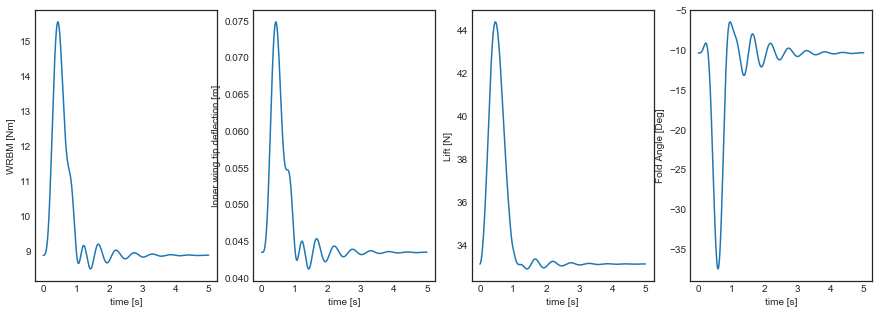

In [21]:
yi = yData.y
t = yData.t

b_shapes = 3
d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)
dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

lift = []
for i in range(len(t)):
    lift.append(nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0])

plt.style.use('seaborn-white')

tup = p.GetNumericTuple([0]*p.qs*2,0)

fig, axes = plt.subplots(1,4,figsize=(15,5))
axes[0].plot(t,d2z_dy2_f(tup,yi[::2])*p.EI.value)
axes[0].set_ylabel('WRBM [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].plot(t,z_tip_f(tup,yi[::2]))
axes[1].set_ylabel('Inner wing tip deflection [m]')
axes[1].set_xlabel('time [s]')

axes[2].plot(t,lift)
axes[2].set_ylabel('Lift [N]')
axes[2].set_xlabel('time [s]')

axes[3].plot(t,np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2])))
axes[3].set_ylabel('Fold Angle [Deg]')
axes[3].set_xlabel('time [s]')

yi[::2].shape